In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

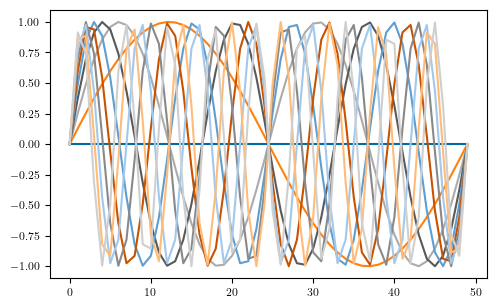

In [3]:
from os import path

# https://jwalton.info/Embed-Publication-Matplotlib-Latex/

PT_PER_INCH = 72.27
GOLDEN_RATIO = (5**.5 - 1) / 2

TEXTWIDTH_PT = 408.0 # \showthe\textwidth
TEXTWIDTH_IN = TEXTWIDTH_PT/PT_PER_INCH

REPORT_PATH = "report"
FIGURES_PATH = path.join("report", "figures")
STYLE_PATH = path.join("report", "thesis.mplstyle")

def figsize(fraction=1.0, width=TEXTWIDTH_IN, ratio=GOLDEN_RATIO, subplots=(1, 1)):
    fig_width = fraction*width
    fig_height = fig_width*ratio*(subplots[0]/subplots[1])
    return fig_width, fig_height

def figpath(name):
    return path.join(FIGURES_PATH, f"{name}.pgf")

plt.style.use(["default", "tableau-colorblind10", STYLE_PATH])
plt.figure(figsize=figsize())
for i in range(10):
    plt.plot(np.sin(np.linspace(0, i*2*np.pi)))
plt.show()


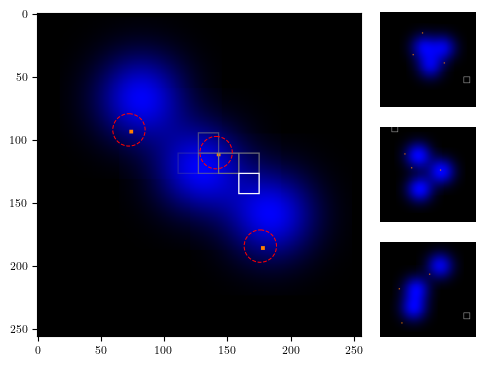

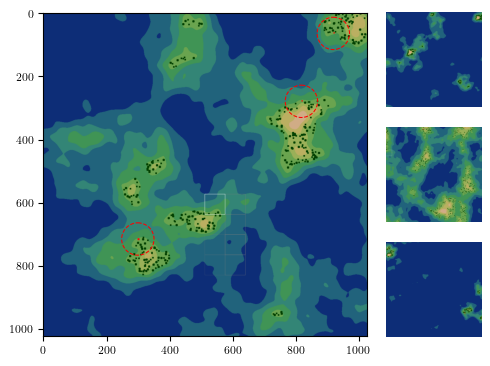

In [58]:
import gym
import gym_search


def plot_environment(env_id, seed=0, count=4, steps=10):
    layout = [
        [0, 0, 0, 1],
        [0, 0, 0, 2],
        [0, 0, 0, 3],
    ]

    fig, axs = plt.subplot_mosaic(layout, figsize=figsize(ratio=0.75))

    env = gym.make(env_id)

    if seed is not None:
        env.seed(seed)

    for i in range(count):
        env.reset()
        
        if i == 0:
            for _ in range(steps):
                env.step(env.action_space.sample())

        img = env.render(mode="rgb_array", show_view=True, show_targets=False, show_hits=False, show_path=True)
        h, w, _c = img.shape

        if i == 0:                
            for t in env.targets:
                #dx = 0.1*w
                #dy = -0.1*w
                #axs[i].arrow(t.x-dx, t.y-dy, dx, dy, color="r", head_width=0.01*w, head_starts_at_zero=True)
                circle = plt.Circle((t.x, t.y), 0.05*w, color='r', fill=False, linewidth=0.75, linestyle='--')
                axs[i].add_patch(circle)


        axs[i].imshow(img)
        if i != 0:
            axs[i].set_axis_off()

    return fig

plot_environment("SearchGaussian-v0", seed=1).savefig(figpath("gaussian"), dpi=300)
plot_environment("SearchTerrain-v0", seed=0).savefig(figpath("terrain"), dpi=300)


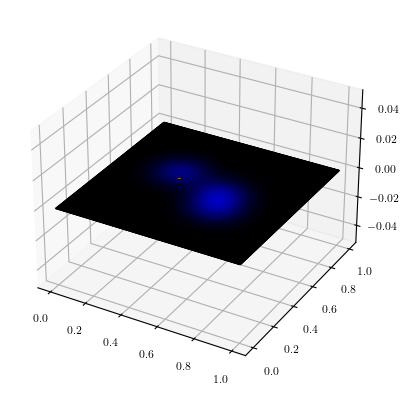

In [54]:
import gym
import gym_search

env = gym.make("SearchGaussian-v0")
obs = env.reset()
img = env.render(mode="rgb_array", show_view=False, show_targets=False, show_hits=False, show_path=False)

h, w, _c = img.shape

# https://stackoverflow.com/questions/25287861/creating-intersecting-images-in-matplotlib-with-imshow-or-other-function/25295272#25295272

fig = plt.figure()
ax = plt.axes(projection='3d')

#points = [(10, 20, 1), (4, 1, 3)]
#xs, ys, zs = zip(*points)
#ax.scatter(xs, ys, zs)
#ax.grid(False)

xx, yy = np.meshgrid(np.linspace(0, 1, h), np.linspace(0, 1, w))
zz = np.zeros((h, w))
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, facecolors=img/255)

#view = env.view
#ax.add_patch(mpl.patches.Rectangle(view.pos, *view.shape, linewidth=1, edgecolor="r"))

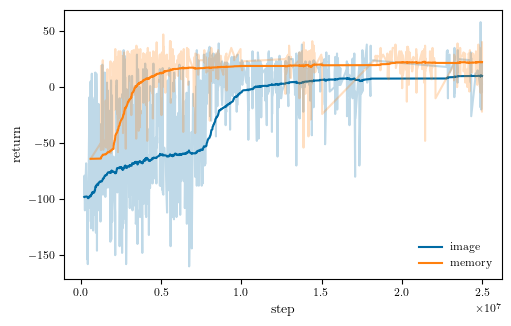

In [45]:
from scipy import stats

def smooth(scalars, weight):
    last = scalars[0]
    smoothed = []

    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

def plot_tboard(paths, labels, xlabel="step", ylabel="value", smoothing=0.0, original=False, outliers=False):
    fig, ax = plt.subplots(figsize=figsize())

    for path, label in zip(paths, labels):
        df = pd.read_csv(path)

        if not outliers:
            df = df[(np.abs(stats.zscore(df["Value"])) < 3)]

        x = df["Step"]
        y = df["Value"]

        p = ax.plot(x, smooth(list(y), smoothing), label=label)
        
        if original:
            ax.plot(x, y, alpha=0.25, color=p[0].get_color())

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(frameon=False)
    return fig

logs = ["logs/run-gaussian-image-tag-charts_episode_return.csv", "logs/run-gaussian-memory-tag-charts_episode_return.csv"]
labels = ["image", "memory"]

fig = plot_tboard(logs, labels, ylabel="return", smoothing=0.99, original=True)

In [63]:
import pandas as pd

def plot_hparams(hparams):
    df = pd.DataFrame({key: [value] for key, value in hparams.items()})
    return df.to_latex()

plot_hparams({"lr": 0.1, "steps": 10000})

,lr,steps
0,0.1,10000
